In [69]:

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


In [3]:

df = pd.read_csv('DogeCoin.csv')


df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


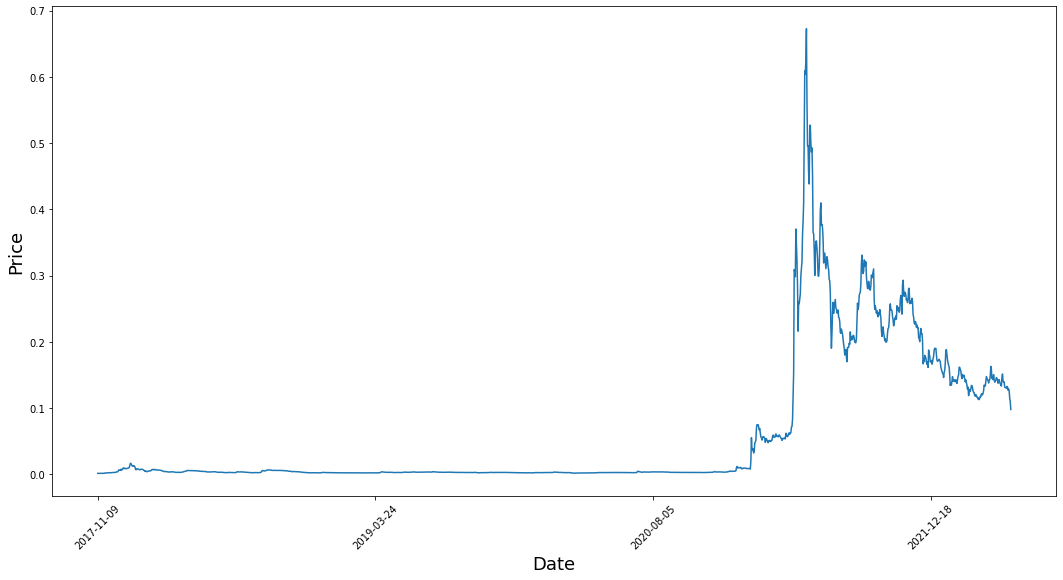

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

Text(0, 0.5, 'Close Price (USD)')

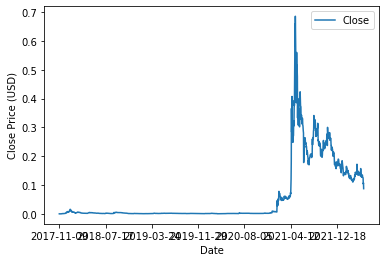

In [7]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)


In [9]:
scaled_close.shape

(1645, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [12]:
scaled_close = scaled_close.reshape(-1, 1)

In [13]:
np.isnan(scaled_close).any()

False

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(1467, 99, 1)

In [16]:
X_test.shape

(78, 99, 1)

In [68]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1], 1))
X_test.shape

(78, 99, 1)

In [87]:
from tensorflow.keras.layers import Flatten
model = Sequential()
model.add(Flatten(input_shape=(99, 1)))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='SGD')


In [88]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [90]:
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 2/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 3/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 4/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 5/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 6/10
1467/1467 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 7/10
1467/1467 [==============================] - 2s 2ms/step - loss: 8.3812e-04
Epoch 8/10
1467/1467 [==============================] - 2s 2ms/step - loss: 8.2082e-04
Epoch 9/10
1467/1467 [==============================] - 2s 2ms/step - loss: 8.3695e-04
Epoch 10/10
1467/1467 [==============================] - 2s 2ms/step - loss: 7.2324e-04


In [91]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 8.9110e-04


0.0008911018376238644

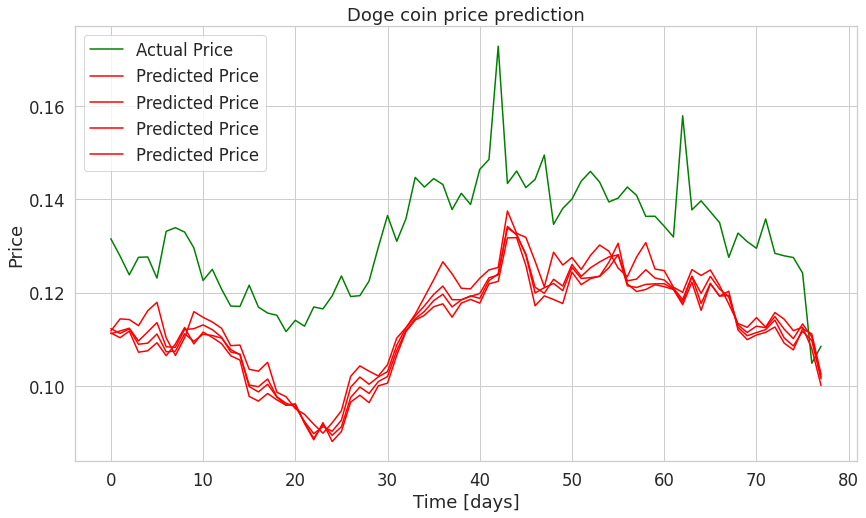

In [96]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Doge coin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();